In [1]:
import numpy as np
import pandas as pd

import time
from datetime import datetime

import gensim
import matplotlib.pyplot as plt

import en_nlp_utils
import model_evaluation_utils

In [2]:
# Define default source path
SRC_PATH = "src/"

start_time = datetime.now()
print("Text processing started at {}".format(start_time))

Text processing started at 2024-06-27 07:59:57.802728


In [3]:
# Load dataset
df_review = pd.read_csv(SRC_PATH + "en_hotel_review.csv")

In [4]:
# Check NULL values
en_nlp_utils.check_null(df_review, "df_review")

# Remove rows when "review_cleaned_v3" is NULL
df_review = df_review.dropna(subset=["review_cleaned_v3"]).reset_index(drop=True)

df_review:
source                      0
hotel_id                    0
hotel_name                  0
country                     0
group_name                  0
room_type                   0
stay_length                 0
stay_date                   0
review_score                0
review_score_category       0
sentiment                   0
review_date                 0
review_title                1
review                      0
review_cleaned_v1           0
review_cleaned_v2           0
review_cleaned_v3        1635
dtype: int64
Total rows in df_review: 39602 



## 1) Using full dataset

In [5]:
# Convert "stay_date" and "review_date" columns as datetime data type
df_review["stay_date"] = pd.to_datetime(df_review["stay_date"], format="%d/%m/%Y")

# Count number of reviews based on year and sentiment
sentiment_count = df_review.groupby([df_review["sentiment"], df_review["stay_date"].dt.year]).size().reset_index(name="count")
sentiment_count2 = sentiment_count.pivot_table(index="stay_date", columns="sentiment", values="count", 
                                               aggfunc="sum", margins=True, margins_name="Total")
sentiment_count2.columns.name = None
sentiment_count2

,negative,positive,Total
stay_date,,,
2022,1651,5244,6895
2023,5225,20226,25451
2024,1075,4546,5621
Total,7951,30016,37967


## 2) Topic Modeling

### a) Helper functions

In [6]:
# Function to generate bow corpus
def generate_bow_corpus(df, target_text):
    
    documents = [en_nlp_utils.tokenize_sentence_to_words(cleaned_review) for cleaned_review in df[target_text]]
    
    bigram = gensim.models.Phrases(documents, min_count=20, threshold=20, delimiter="_") # higher threshold fewer phrases.
    bigram_model = gensim.models.phrases.Phraser(bigram)
    
    corpus_bigrams = [bigram_model[doc] for doc in documents]
    dictionary = gensim.corpora.Dictionary(corpus_bigrams)
    dictionary.filter_extremes(no_below=20, no_above=0.6)
    bow_corpus = [dictionary.doc2bow(text) for text in corpus_bigrams]
    
    return bow_corpus, corpus_bigrams, dictionary


# Function to calculate all models' coherence scores
def topic_model_coherence_plot(df, df_name, target_text, MODEL_NAMES, START_TOPIC_COUNT, END_TOPIC_COUNT):
    
    overall_coherence_df = pd.DataFrame() # Store each model's coherence scores
    model_topic_info = [] # Store each model's topic information
    
    bow_corpus, corpus_bigrams, dictionary = generate_bow_corpus(df, target_text)
    model_count = 0
    
    for MODEL_NAME in MODEL_NAMES:
        models, coherence_scores = en_nlp_utils.topic_model_coherence_generator(model_name=MODEL_NAME,
                                                                                corpus=bow_corpus,
                                                                                texts=corpus_bigrams,
                                                                                dictionary=dictionary,
                                                                                start_topic_count=START_TOPIC_COUNT,
                                                                                end_topic_count=END_TOPIC_COUNT,
                                                                                step=1,
                                                                                cpus=-1,
                                                                                print_topics=True)

        coherence_df = pd.DataFrame({"Model Name": MODEL_NAME, 
                                     "Number of Topics": range(START_TOPIC_COUNT, END_TOPIC_COUNT + 1, 1), 
                                     "Coherence Score": np.round(coherence_scores, 6),
                                     "df_name": df_name})
        coherence_df.sort_values(by=["Coherence Score"], ascending=False)
        print(coherence_df)
        
        overall_coherence_df = pd.concat([overall_coherence_df, coherence_df], axis=0)
        
        model_topics = []
        for model in models:
            num_topics = model.num_topics
            topics = [[(term, round(wt, 3)) for term, wt in model.show_topic(n, topn=10)] for n in range(num_topics)]
            
            # Determine the number of columns dynamically
            num_terms_per_topic = max(len(topic) for topic in topics)
            
            # Create a DataFrame for topics with dynamic columns and names
            topics_df = pd.DataFrame([[term if len(topic) > i else "" for i, (term, wt) in enumerate(topic)]
                                      for topic in topics],
                                     columns=[f"Term{i+1}" for i in range(num_terms_per_topic)],
                                     index=[f"Topic {t+1}" for t in range(num_topics)]).T
            
            model_topic_info.append({
                "Model Name": MODEL_NAME,
                "Number of Topics": num_topics,
                "Topics": topics_df.to_dict(orient="list"),  # Convert DataFrame to dictionary
                "df_name": df_name
            })
        
        x_ax = range(START_TOPIC_COUNT, END_TOPIC_COUNT + 1, 1)
        y_ax = coherence_scores
        plt.figure(num=model_count, figsize=(15, 12))
        plt.plot(x_ax, y_ax, c="r")
        plt.axhline(y=0.3, c="k", linestyle="--", linewidth=2)
        plt.axhline(y=0.4, c="k", linestyle="--", linewidth=2)
        plt.axhline(y=0.5, c="k", linestyle="--", linewidth=2)
        plt.rcParams["figure.facecolor"] = "white"
        xl = plt.xlabel("Number of Topics")
        yl = plt.ylabel("Coherence Score")

        model_count += 1

    plt.show()
    return overall_coherence_df, model_topic_info


# Function to print best model's topics
def print_best_model_topics(overall_coherence_best_df, model_topic_info_list):
    
    for index, row in overall_coherence_best_df.iterrows():
        model_name = row["Model Name"]
        num_topics = row["Number of Topics"]
        df_name = row["df_name"]
        
        print(f"\nDF NAME: {df_name}\nMODEL: {model_name} - NUMBER OF TOPICS: {num_topics}")
       
        # Find the corresponding model_topic_info
        for model_topic_info in model_topic_info_list:
            for model_info in model_topic_info:
                if (model_info["Model Name"] == model_name and
                    model_info["Number of Topics"] == num_topics and
                    model_info["df_name"] == df_name):
                    
                    topics = model_info["Topics"]
                    for topic_num, terms in topics.items():
                        print(f"\n{topic_num}: {', '.join(terms)}")
                        
                    print("\n----------\n")
                    break

### b) Topic Modeling

In [7]:
# Filter positive and negative reviews and save into different dataframe
df_pos = df_review[df_review["sentiment"] == "positive"].reset_index(drop=True)
df_neg = df_review[df_review["sentiment"] == "negative"].reset_index(drop=True)

In [8]:
MODEL_NAMES = ["LSI", "LDA"]
START_TOPIC_COUNT = 2
END_TOPIC_COUNT = 10

df_sets = [df_pos, df_neg]
df_names = ["df_pos", "df_neg"]


DF NAME: df_pos



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LSI - NUMBER OF TOPICS: 2


 11%|█████████                                                                        | 1/9 [09:16<1:14:12, 556.53s/it]

Topic #1:
0.367*"great" + 0.202*"friendly" + 0.175*"station" + 0.165*"breakfast" + 0.165*"food" + 0.153*"helpful" + 0.142*"singapore" + 0.141*"really" + 0.138*"overall" + 0.131*"service" + 0.130*"bathroom" + 0.127*"walk" + 0.125*"close" + 0.122*"comfortable" + 0.120*"restaurant" + 0.116*"shower" + 0.108*"facility" + 0.106*"provide" + 0.106*"price" + 0.104*"pool"

Topic #2:
-0.849*"great" + 0.109*"bathroom" + 0.103*"toilet" + 0.098*"shower" + 0.087*"use" + 0.086*"station" + 0.076*"quite" + 0.074*"reception" + 0.073*"god" + -0.073*"friendly" + 0.067*"really" + 0.065*"sleep" + 0.064*"still" + 0.062*"find" + 0.062*"tell" + 0.057*"provide" + 0.057*"water" + 0.056*"wait" + 0.056*"change" + -0.055*"pool"

--------------------------------------------------

MODEL: LSI - NUMBER OF TOPICS: 3


 22%|██████████████████                                                               | 2/9 [18:50<1:06:08, 566.99s/it]

Topic #1:
0.371*"great" + 0.204*"friendly" + 0.176*"station" + 0.165*"food" + 0.163*"breakfast" + 0.154*"helpful" + 0.142*"singapore" + 0.140*"really" + 0.138*"overall" + 0.130*"service" + 0.129*"bathroom" + 0.127*"walk" + 0.126*"close" + 0.123*"comfortable" + 0.121*"restaurant" + 0.114*"shower" + 0.109*"facility" + 0.106*"price" + 0.105*"provide" + 0.103*"use"

Topic #2:
-0.864*"great" + 0.104*"station" + 0.101*"shower" + 0.098*"bathroom" + 0.088*"toilet" + 0.087*"use" + 0.079*"quite" + 0.066*"really" + 0.066*"provide" + 0.063*"water" + 0.061*"reception" + -0.060*"friendly" + 0.059*"still" + 0.058*"change" + 0.055*"walk" + 0.054*"next" + 0.054*"find" + 0.053*"sleep" + 0.053*"want" + 0.052*"enough"

Topic #3:
0.587*"station" + 0.255*"food" + -0.194*"service" + 0.179*"bus" + 0.151*"close" + 0.148*"restaurant" + -0.134*"reception" + -0.134*"god" + -0.133*"shower" + 0.121*"convenient" + -0.119*"toilet" + -0.109*"wait" + -0.108*"call" + 0.106*"walk" + -0.104*"tell" + -0.100*"great" + -0.09

 33%|███████████████████████████▋                                                       | 3/9 [28:33<57:24, 574.06s/it]

Topic #1:
0.368*"great" + 0.207*"friendly" + 0.177*"station" + 0.166*"food" + 0.160*"breakfast" + 0.156*"helpful" + 0.143*"singapore" + 0.140*"really" + 0.139*"overall" + 0.130*"service" + 0.129*"bathroom" + 0.127*"walk" + 0.126*"close" + 0.123*"comfortable" + 0.121*"restaurant" + 0.113*"shower" + 0.109*"facility" + 0.106*"provide" + 0.105*"price" + 0.102*"use"

Topic #2:
-0.876*"great" + 0.120*"station" + 0.090*"shower" + 0.086*"bathroom" + 0.082*"use" + 0.080*"quite" + 0.080*"toilet" + 0.072*"provide" + 0.063*"walk" + 0.062*"really" + 0.060*"water" + 0.056*"reception" + 0.056*"still" + 0.055*"mind" + 0.052*"next" + 0.052*"find" + 0.051*"change" + 0.050*"want" + 0.050*"enough" + 0.050*"towel"

Topic #3:
0.547*"station" + 0.259*"friendly" + 0.197*"food" + 0.174*"bus" + 0.171*"helpful" + -0.154*"service" + -0.154*"shower" + 0.137*"walk" + -0.128*"toilet" + -0.126*"breakfast" + 0.121*"convenient" + 0.119*"close" + -0.116*"reception" + -0.111*"tell" + -0.108*"god" + -0.106*"call" + 0.103*

 44%|████████████████████████████████████▉                                              | 4/9 [38:23<48:22, 580.44s/it]

Topic #1:
0.368*"great" + 0.206*"friendly" + 0.179*"station" + 0.166*"food" + 0.160*"breakfast" + 0.155*"helpful" + 0.143*"singapore" + 0.140*"really" + 0.139*"overall" + 0.130*"service" + 0.129*"walk" + 0.128*"bathroom" + 0.127*"close" + 0.123*"comfortable" + 0.122*"restaurant" + 0.113*"shower" + 0.109*"facility" + 0.106*"price" + 0.105*"provide" + 0.102*"use"

Topic #2:
-0.876*"great" + 0.126*"station" + 0.093*"shower" + 0.085*"bathroom" + 0.083*"use" + 0.082*"quite" + 0.079*"toilet" + 0.070*"provide" + 0.069*"walk" + 0.063*"really" + 0.062*"water" + 0.059*"mind" + 0.055*"reception" + 0.054*"still" + 0.051*"towel" + 0.051*"bus" + 0.051*"find" + 0.051*"next" + 0.049*"enough" + 0.049*"change"

Topic #3:
0.475*"station" + 0.389*"friendly" + 0.234*"helpful" + -0.153*"shower" + 0.151*"bus" + -0.142*"bathroom" + 0.133*"convenient" + -0.129*"great" + 0.126*"food" + -0.123*"toilet" + 0.116*"walk" + 0.113*"restaurant" + -0.112*"reception" + -0.111*"tell" + -0.109*"use" + -0.105*"call" + -0.10

 56%|██████████████████████████████████████████████                                     | 5/9 [48:18<39:03, 585.76s/it]

Topic #1:
0.368*"great" + 0.206*"friendly" + 0.180*"station" + 0.167*"food" + 0.161*"breakfast" + 0.156*"helpful" + 0.143*"singapore" + 0.139*"really" + 0.139*"overall" + 0.129*"walk" + 0.129*"service" + 0.128*"close" + 0.128*"bathroom" + 0.123*"comfortable" + 0.123*"restaurant" + 0.113*"shower" + 0.109*"facility" + 0.105*"price" + 0.105*"provide" + 0.102*"use"

Topic #2:
-0.880*"great" + 0.127*"station" + 0.090*"shower" + 0.082*"use" + 0.082*"bathroom" + 0.079*"quite" + 0.076*"toilet" + 0.070*"walk" + 0.069*"provide" + 0.064*"really" + 0.060*"water" + 0.060*"mind" + 0.053*"reception" + 0.052*"food" + 0.052*"still" + 0.052*"bus" + 0.051*"next" + 0.050*"towel" + 0.050*"find" + 0.049*"close"

Topic #3:
0.539*"friendly" + 0.360*"station" + 0.303*"helpful" + -0.159*"shower" + -0.153*"great" + -0.142*"bathroom" + -0.123*"toilet" + -0.121*"use" + 0.120*"convenient" + -0.118*"service" + 0.109*"bus" + -0.100*"call" + 0.098*"food" + -0.095*"tell" + -0.093*"really" + 0.091*"restaurant" + -0.088*

 67%|███████████████████████████████████████████████████████▎                           | 6/9 [58:23<29:36, 592.16s/it]

Topic #1:
0.368*"great" + 0.207*"friendly" + 0.179*"station" + 0.168*"food" + 0.160*"breakfast" + 0.156*"helpful" + 0.143*"singapore" + 0.139*"really" + 0.139*"overall" + 0.129*"bathroom" + 0.129*"walk" + 0.128*"service" + 0.128*"close" + 0.123*"comfortable" + 0.122*"restaurant" + 0.114*"shower" + 0.109*"facility" + 0.106*"price" + 0.105*"provide" + 0.102*"use"

Topic #2:
-0.881*"great" + 0.128*"station" + 0.091*"shower" + 0.083*"bathroom" + 0.082*"use" + 0.080*"quite" + 0.076*"toilet" + 0.075*"walk" + 0.067*"provide" + 0.066*"really" + 0.063*"mind" + 0.060*"water" + 0.060*"food" + 0.054*"reception" + 0.052*"still" + 0.051*"bus" + 0.050*"close" + 0.050*"find" + 0.050*"next" + 0.049*"towel"

Topic #3:
0.524*"friendly" + 0.358*"station" + 0.282*"helpful" + -0.190*"shower" + -0.170*"bathroom" + -0.154*"great" + -0.146*"toilet" + -0.128*"use" + 0.116*"convenient" + 0.113*"food" + 0.112*"bus" + -0.103*"really" + 0.102*"restaurant" + -0.097*"water" + 0.096*"singapore" + -0.087*"still" + -0.0

 78%|███████████████████████████████████████████████████████████████                  | 7/9 [1:08:32<19:55, 597.61s/it]

Topic #1:
0.368*"great" + 0.207*"friendly" + 0.179*"station" + 0.168*"food" + 0.161*"breakfast" + 0.156*"helpful" + 0.143*"singapore" + 0.139*"overall" + 0.138*"really" + 0.129*"walk" + 0.128*"bathroom" + 0.128*"service" + 0.128*"close" + 0.123*"comfortable" + 0.122*"restaurant" + 0.114*"shower" + 0.108*"facility" + 0.106*"price" + 0.105*"provide" + 0.102*"use"

Topic #2:
-0.883*"great" + 0.126*"station" + 0.093*"shower" + 0.083*"bathroom" + 0.081*"use" + 0.080*"quite" + 0.077*"toilet" + 0.071*"walk" + 0.067*"provide" + 0.064*"really" + 0.060*"mind" + 0.060*"water" + 0.058*"food" + 0.052*"still" + 0.051*"reception" + 0.050*"close" + 0.050*"next" + 0.050*"find" + 0.049*"bus" + 0.049*"singapore"

Topic #3:
0.730*"friendly" + 0.372*"helpful" + -0.199*"great" + -0.150*"shower" + -0.123*"bathroom" + -0.113*"toilet" + -0.109*"use" + -0.089*"walk" + 0.086*"convenient" + 0.084*"comfortable" + -0.079*"water" + 0.079*"singapore" + -0.077*"really" + 0.077*"excellent" + 0.069*"overall" + -0.067*"s

 89%|████████████████████████████████████████████████████████████████████████         | 8/9 [1:18:47<10:03, 603.16s/it]

Topic #1:
0.368*"great" + 0.207*"friendly" + 0.178*"station" + 0.168*"food" + 0.161*"breakfast" + 0.155*"helpful" + 0.143*"singapore" + 0.139*"really" + 0.138*"overall" + 0.129*"walk" + 0.128*"close" + 0.128*"bathroom" + 0.127*"service" + 0.123*"comfortable" + 0.122*"restaurant" + 0.114*"shower" + 0.108*"facility" + 0.106*"price" + 0.105*"provide" + 0.102*"use"

Topic #2:
-0.884*"great" + 0.123*"station" + 0.092*"shower" + 0.082*"quite" + 0.081*"bathroom" + 0.079*"use" + 0.077*"toilet" + 0.073*"walk" + 0.066*"provide" + 0.065*"really" + 0.061*"mind" + 0.060*"water" + 0.059*"food" + 0.053*"still" + 0.052*"close" + 0.050*"next" + 0.050*"singapore" + 0.050*"reception" + 0.049*"find" + 0.048*"bus"

Topic #3:
0.745*"friendly" + 0.386*"helpful" + -0.187*"great" + -0.145*"shower" + -0.109*"bathroom" + -0.105*"toilet" + -0.101*"use" + 0.086*"convenient" + 0.086*"comfortable" + -0.078*"water" + -0.072*"really" + 0.070*"excellent" + 0.063*"singapore" + -0.061*"still" + -0.061*"sleep" + -0.058*"w

100%|█████████████████████████████████████████████████████████████████████████████████| 9/9 [1:29:09<00:00, 594.39s/it]


Topic #1:
0.367*"great" + 0.207*"friendly" + 0.178*"station" + 0.168*"food" + 0.162*"breakfast" + 0.155*"helpful" + 0.143*"singapore" + 0.139*"really" + 0.138*"overall" + 0.129*"walk" + 0.128*"bathroom" + 0.128*"close" + 0.127*"service" + 0.123*"comfortable" + 0.122*"restaurant" + 0.114*"shower" + 0.108*"facility" + 0.106*"price" + 0.105*"provide" + 0.102*"use"

Topic #2:
-0.884*"great" + 0.123*"station" + 0.092*"shower" + 0.082*"quite" + 0.080*"bathroom" + 0.078*"use" + 0.078*"toilet" + 0.073*"walk" + 0.066*"really" + 0.065*"provide" + 0.061*"mind" + 0.059*"water" + 0.058*"food" + 0.053*"still" + 0.052*"close" + 0.051*"singapore" + 0.051*"next" + 0.049*"reception" + 0.049*"bus" + 0.048*"find"

Topic #3:
0.767*"friendly" + 0.399*"helpful" + -0.181*"great" + -0.130*"shower" + -0.093*"bathroom" + -0.092*"use" + -0.086*"toilet" + 0.082*"comfortable" + 0.081*"convenient" + -0.074*"walk" + -0.071*"water" + -0.065*"food" + -0.063*"really" + 0.062*"excellent" + -0.060*"price" + 0.058*"facilit

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LDA - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:10<01:22, 10.33s/it]

Topic #1:
0.017*"station" + 0.016*"close" + 0.013*"restaurant" + 0.012*"food" + 0.010*"walk" + 0.009*"lot" + 0.008*"friendly" + 0.008*"convenient" + 0.008*"quite" + 0.007*"walk_distance" + 0.007*"breakfast" + 0.006*"many" + 0.006*"mind" + 0.006*"comfortable" + 0.006*"use" + 0.006*"bathroom" + 0.006*"shower" + 0.006*"super" + 0.006*"helpful" + 0.006*"toilet"

Topic #2:
0.035*"great" + 0.020*"friendly" + 0.017*"helpful" + 0.012*"breakfast" + 0.012*"service" + 0.012*"pool" + 0.012*"facility" + 0.011*"comfortable" + 0.011*"singapore" + 0.009*"excellent" + 0.009*"really" + 0.008*"perfect" + 0.008*"view" + 0.008*"love" + 0.008*"price" + 0.007*"amazing" + 0.007*"everything" + 0.006*"experience" + 0.006*"spacious" + 0.005*"bathroom"

--------------------------------------------------

MODEL: LDA - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:23<01:25, 12.15s/it]

Topic #1:
0.011*"bathroom" + 0.011*"shower" + 0.010*"great" + 0.010*"comfortable" + 0.010*"really" + 0.009*"work" + 0.008*"toilet" + 0.008*"big" + 0.008*"space" + 0.007*"close" + 0.007*"enough" + 0.007*"smell" + 0.007*"sleep" + 0.006*"quite" + 0.006*"hostel" + 0.006*"value_money" + 0.006*"window" + 0.005*"spacious" + 0.005*"inside" + 0.005*"iron"

Topic #2:
0.021*"friendly" + 0.019*"helpful" + 0.010*"facility" + 0.010*"everything" + 0.010*"price" + 0.010*"overall" + 0.008*"service" + 0.008*"experience" + 0.007*"ok" + 0.007*"comfortable" + 0.007*"cleanliness" + 0.007*"great" + 0.007*"recommend" + 0.006*"property" + 0.006*"really" + 0.006*"singapore" + 0.006*"bathroom" + 0.006*"nothing" + 0.006*"reception" + 0.005*"provide"

Topic #3:
0.041*"great" + 0.020*"breakfast" + 0.019*"station" + 0.018*"close" + 0.017*"food" + 0.017*"restaurant" + 0.016*"friendly" + 0.014*"pool" + 0.011*"walk" + 0.011*"excellent" + 0.011*"convenient" + 0.009*"service" + 0.009*"love" + 0.009*"walk_distance" + 0.00

 33%|████████████████████████████                                                        | 3/9 [00:35<01:12, 12.10s/it]

Topic #1:
0.056*"great" + 0.039*"friendly" + 0.029*"helpful" + 0.024*"breakfast" + 0.018*"comfortable" + 0.017*"pool" + 0.015*"excellent" + 0.014*"view" + 0.013*"facility" + 0.013*"food" + 0.013*"love" + 0.012*"everything" + 0.012*"restaurant" + 0.011*"amazing" + 0.010*"close" + 0.009*"value_money" + 0.009*"perfect" + 0.009*"service" + 0.008*"spacious" + 0.008*"really"

Topic #2:
0.034*"station" + 0.018*"walk" + 0.017*"close" + 0.013*"convenient" + 0.012*"restaurant" + 0.012*"mind" + 0.012*"bus" + 0.011*"walk_distance" + 0.011*"food" + 0.011*"singapore" + 0.009*"little_india" + 0.009*"locate" + 0.008*"easy" + 0.008*"bus_stop" + 0.008*"boris" + 0.008*"right" + 0.007*"retro" + 0.007*"within" + 0.007*"away" + 0.006*"provide"

Topic #3:
0.017*"bathroom" + 0.012*"shower" + 0.010*"toilet" + 0.010*"space" + 0.009*"work" + 0.009*"big" + 0.008*"quite" + 0.008*"use" + 0.008*"price" + 0.007*"close" + 0.007*"share" + 0.007*"people" + 0.007*"enough" + 0.006*"really" + 0.006*"towel" + 0.006*"water" 

 44%|█████████████████████████████████████▎                                              | 4/9 [00:47<00:59, 11.97s/it]

Topic #1:
0.018*"bathroom" + 0.017*"shower" + 0.015*"great" + 0.012*"toilet" + 0.011*"use" + 0.010*"water" + 0.010*"pool" + 0.009*"towel" + 0.008*"work" + 0.008*"lovely" + 0.007*"space" + 0.007*"view" + 0.007*"smell" + 0.007*"breakfast" + 0.006*"window" + 0.006*"light" + 0.006*"first" + 0.006*"enough" + 0.006*"change" + 0.006*"inside"

Topic #2:
0.017*"station" + 0.016*"restaurant" + 0.015*"walk" + 0.012*"food" + 0.011*"mind" + 0.010*"close" + 0.009*"many" + 0.009*"lot" + 0.008*"quite" + 0.007*"big" + 0.007*"great" + 0.007*"share" + 0.007*"boris" + 0.007*"next" + 0.006*"sleep" + 0.006*"walk_distance" + 0.006*"right" + 0.006*"little_india" + 0.005*"find" + 0.005*"price"

Topic #3:
0.050*"friendly" + 0.050*"great" + 0.038*"helpful" + 0.021*"comfortable" + 0.015*"excellent" + 0.015*"everything" + 0.015*"facility" + 0.015*"love" + 0.015*"close" + 0.014*"perfect" + 0.014*"amazing" + 0.014*"station" + 0.013*"convenient" + 0.013*"really" + 0.010*"super" + 0.010*"service" + 0.009*"breakfast" +

 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:59<00:47, 11.92s/it]

Topic #1:
0.017*"friendly" + 0.015*"great" + 0.015*"helpful" + 0.014*"space" + 0.013*"super" + 0.013*"comfortable" + 0.010*"really" + 0.010*"big" + 0.010*"thank" + 0.009*"facility" + 0.009*"family" + 0.009*"pool" + 0.009*"love" + 0.009*"hostel" + 0.009*"bathroom" + 0.008*"recommend" + 0.008*"nothing" + 0.008*"beautiful" + 0.007*"kiss" + 0.007*"much"

Topic #2:
0.060*"great" + 0.028*"breakfast" + 0.022*"friendly" + 0.016*"pool" + 0.016*"view" + 0.016*"comfortable" + 0.016*"singapore" + 0.016*"everything" + 0.014*"helpful" + 0.013*"excellent" + 0.013*"facility" + 0.013*"service" + 0.012*"amazing" + 0.011*"close" + 0.011*"love" + 0.009*"perfect" + 0.009*"food" + 0.008*"restaurant" + 0.008*"lovely" + 0.008*"price"

Topic #3:
0.040*"station" + 0.023*"close" + 0.021*"convenient" + 0.020*"food" + 0.019*"walk" + 0.019*"restaurant" + 0.015*"walk_distance" + 0.013*"bus" + 0.012*"easy" + 0.012*"mind" + 0.011*"many" + 0.011*"lot" + 0.011*"friendly" + 0.010*"helpful" + 0.010*"locate" + 0.009*"bus_s

 67%|████████████████████████████████████████████████████████                            | 6/9 [01:11<00:35, 11.93s/it]

Topic #1:
0.032*"helpful" + 0.025*"great" + 0.022*"friendly" + 0.021*"service" + 0.019*"price" + 0.015*"facility" + 0.014*"everything" + 0.014*"singapore" + 0.012*"really" + 0.009*"nothing" + 0.009*"reception" + 0.008*"capsule" + 0.008*"cleanliness" + 0.008*"excellent" + 0.008*"comfortable" + 0.007*"superb" + 0.007*"convenience" + 0.006*"value_money" + 0.006*"front_desk" + 0.006*"quality"

Topic #2:
0.024*"friendly" + 0.024*"great" + 0.023*"convenient" + 0.018*"recommend" + 0.018*"helpful" + 0.018*"easy" + 0.017*"hostel" + 0.016*"definitely" + 0.016*"accommodation" + 0.013*"singapore" + 0.012*"chinatown" + 0.012*"n" + 0.012*"travel" + 0.011*"food" + 0.010*"love" + 0.010*"really" + 0.010*"accessible" + 0.010*"everything" + 0.010*"next" + 0.010*"super"

Topic #3:
0.018*"ok" + 0.014*"apartment" + 0.014*"sleep" + 0.012*"reception" + 0.011*"value_money" + 0.010*"common" + 0.010*"request" + 0.009*"luggage" + 0.009*"early" + 0.009*"leave" + 0.009*"people" + 0.008*"flight" + 0.008*"next" + 0.0

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [01:23<00:23, 11.92s/it]

Topic #1:
0.061*"great" + 0.027*"excellent" + 0.027*"facility" + 0.026*"comfortable" + 0.026*"friendly" + 0.020*"service" + 0.019*"breakfast" + 0.018*"everything" + 0.015*"singapore" + 0.014*"helpful" + 0.014*"amazing" + 0.014*"perfect" + 0.013*"value_money" + 0.013*"property" + 0.012*"overall" + 0.012*"nothing" + 0.011*"experience" + 0.011*"provide" + 0.009*"amenity" + 0.009*"cleanliness"

Topic #2:
0.038*"friendly" + 0.038*"close" + 0.033*"food" + 0.031*"restaurant" + 0.029*"helpful" + 0.026*"great" + 0.025*"station" + 0.021*"convenient" + 0.020*"lot" + 0.019*"walk" + 0.016*"walk_distance" + 0.016*"easy" + 0.013*"chinatown" + 0.012*"accessible" + 0.012*"right" + 0.011*"super" + 0.010*"shop" + 0.010*"locate" + 0.009*"many" + 0.009*"ok"

Topic #3:
0.010*"inside" + 0.008*"price" + 0.008*"use" + 0.007*"pay" + 0.007*"apartment" + 0.007*"iron" + 0.007*"provide" + 0.007*"thing" + 0.007*"sundry" + 0.007*"want" + 0.006*"money" + 0.006*"big" + 0.006*"enough" + 0.006*"help" + 0.006*"really" + 0

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [01:38<00:13, 13.11s/it]

Topic #1:
0.018*"reception" + 0.017*"provide" + 0.014*"request" + 0.013*"service" + 0.012*"towel" + 0.011*"helpful" + 0.010*"front_desk" + 0.008*"use" + 0.008*"thank" + 0.008*"pillow" + 0.008*"change" + 0.007*"help" + 0.007*"bathroom" + 0.007*"share" + 0.007*"comfortable" + 0.006*"late" + 0.006*"two" + 0.006*"privacy" + 0.006*"shower" + 0.006*"pad"

Topic #2:
0.027*"hostel" + 0.017*"apartment" + 0.013*"luggage" + 0.013*"breakfast" + 0.011*"help" + 0.011*"god" + 0.010*"light" + 0.009*"japan_bear" + 0.009*"leave" + 0.009*"early" + 0.008*"able" + 0.008*"lobby" + 0.008*"lift" + 0.008*"use" + 0.008*"flight" + 0.007*"bag" + 0.007*"want" + 0.007*"th" + 0.006*"way" + 0.006*"service"

Topic #3:
0.041*"station" + 0.037*"friendly" + 0.036*"close" + 0.029*"restaurant" + 0.027*"helpful" + 0.021*"food" + 0.020*"convenient" + 0.019*"great" + 0.018*"comfortable" + 0.017*"walk_distance" + 0.015*"singapore" + 0.014*"many" + 0.014*"lot" + 0.014*"locate" + 0.013*"excellent" + 0.013*"value_money" + 0.012*"

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:54<00:00, 12.75s/it]

Topic #1:
0.031*"shower" + 0.027*"toilet" + 0.022*"hostel" + 0.022*"bathroom" + 0.021*"ok" + 0.013*"sleep" + 0.013*"feel" + 0.012*"water" + 0.010*"really" + 0.008*"okay" + 0.008*"hot" + 0.008*"great" + 0.008*"see" + 0.007*"private" + 0.007*"window" + 0.007*"kind" + 0.006*"overall" + 0.006*"work" + 0.006*"move" + 0.006*"fabulous"

Topic #2:
0.049*"service" + 0.036*"excellent" + 0.035*"great" + 0.030*"facility" + 0.024*"friendly" + 0.023*"value_money" + 0.022*"helpful" + 0.016*"thank" + 0.013*"amazing" + 0.010*"property" + 0.010*"exceptional" + 0.009*"everything" + 0.009*"fantastic" + 0.009*"help" + 0.008*"especially" + 0.008*"singapore" + 0.008*"experience" + 0.007*"welcome" + 0.007*"wonderful" + 0.007*"front_desk"

Topic #3:
0.045*"pool" + 0.025*"love" + 0.020*"kiss" + 0.017*"awesome" + 0.014*"n" + 0.013*"experience" + 0.011*"spend" + 0.010*"friendly" + 0.010*"way" + 0.009*"really" + 0.009*"customer_service" + 0.009*"mattress" + 0.009*"cosy" + 0.008*"cool" + 0.007*"wonderful" + 0.007*"

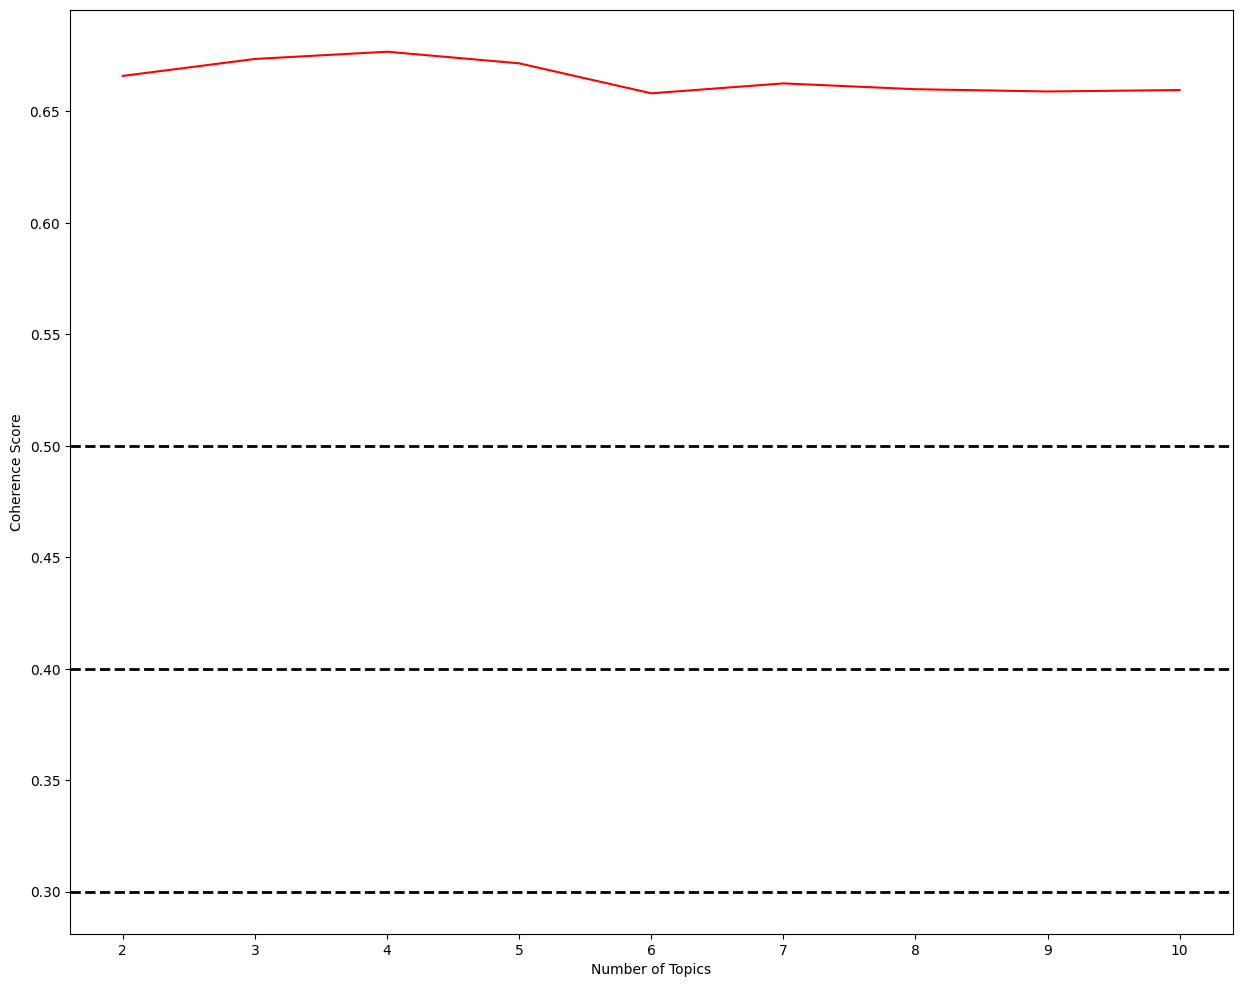

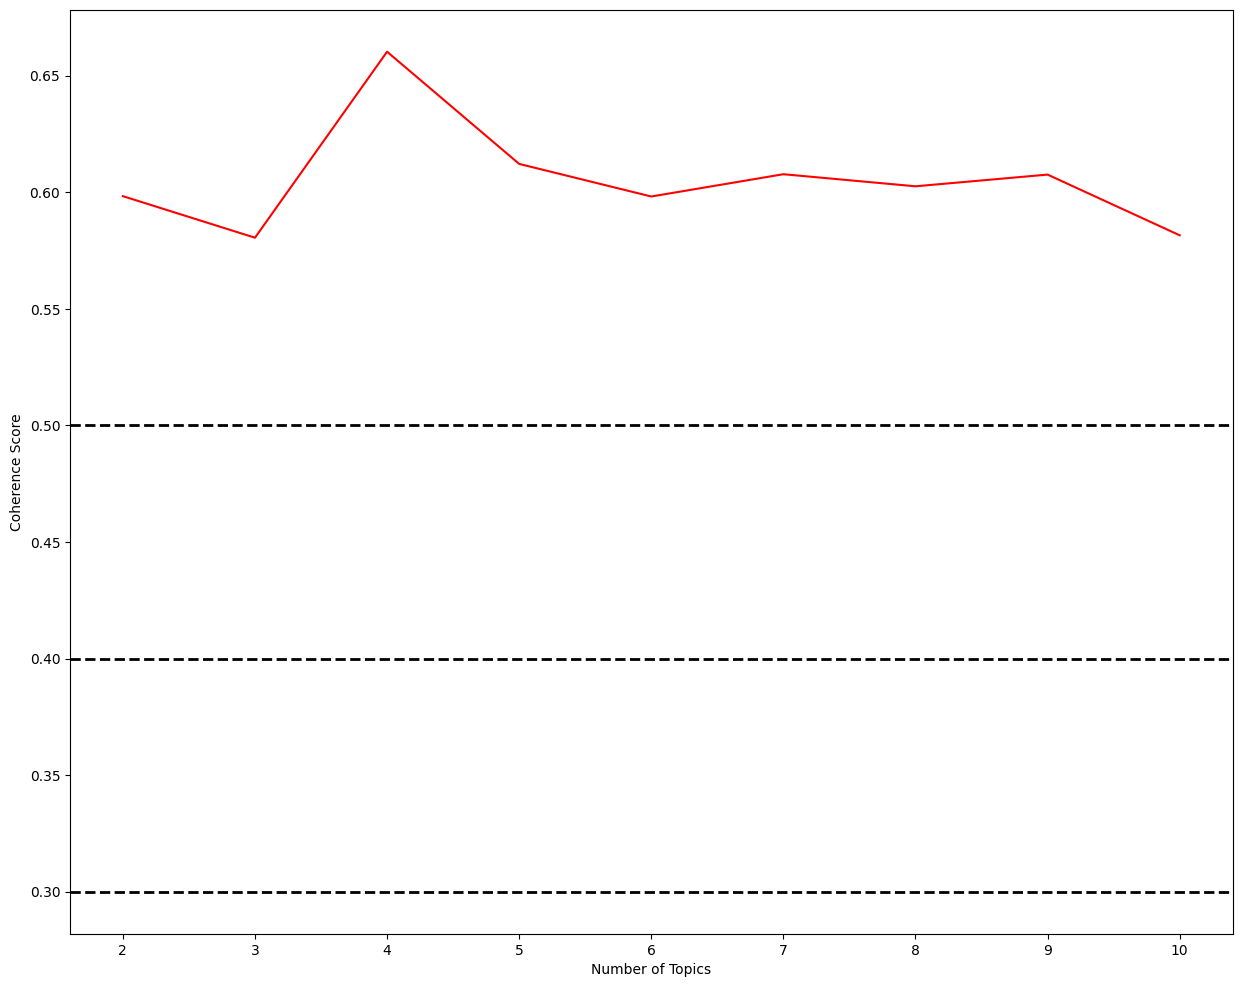


DF NAME: df_neg



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LSI - NUMBER OF TOPICS: 2


 11%|█████████▏                                                                         | 1/9 [02:14<17:56, 134.62s/it]

Topic #1:
0.179*"shower" + 0.171*"service" + 0.164*"bathroom" + 0.160*"reception" + 0.155*"water" + 0.154*"breakfast" + 0.146*"toilet" + 0.138*"smell" + 0.135*"pay" + 0.131*"dirty" + 0.122*"first" + 0.121*"use" + 0.120*"work" + 0.120*"change" + 0.119*"towel" + 0.117*"call" + 0.116*"want" + 0.114*"look" + 0.114*"request" + 0.113*"tell"

Topic #2:
-0.359*"shower" + -0.322*"bathroom" + 0.274*"wait" + -0.273*"toilet" + 0.249*"tell" + -0.229*"smell" + 0.219*"call" + 0.215*"breakfast" + 0.201*"service" + -0.176*"water" + -0.172*"dirty" + 0.135*"pay" + 0.123*"mind" + 0.110*"request" + 0.097*"reception" + -0.092*"old" + 0.084*"want" + -0.080*"hostel" + 0.078*"front_desk" + -0.077*"wall"

--------------------------------------------------

MODEL: LSI - NUMBER OF TOPICS: 3


 22%|██████████████████▍                                                                | 2/9 [04:30<15:47, 135.41s/it]

Topic #1:
0.179*"shower" + 0.171*"service" + 0.167*"bathroom" + 0.160*"reception" + 0.155*"water" + 0.150*"breakfast" + 0.147*"toilet" + 0.140*"smell" + 0.135*"pay" + 0.132*"dirty" + 0.122*"first" + 0.122*"work" + 0.120*"use" + 0.119*"change" + 0.118*"towel" + 0.117*"want" + 0.115*"call" + 0.115*"look" + 0.114*"request" + 0.112*"experience"

Topic #2:
-0.359*"shower" + 0.344*"breakfast" + -0.304*"toilet" + -0.296*"bathroom" + -0.224*"smell" + 0.222*"tell" + 0.213*"wait" + 0.212*"service" + -0.191*"dirty" + -0.191*"water" + 0.180*"call" + 0.164*"pay" + 0.098*"mind" + 0.097*"request" + 0.088*"want" + -0.084*"old" + 0.082*"reception" + -0.079*"stain" + -0.074*"wall" + 0.071*"front_desk"

Topic #3:
-0.568*"breakfast" + 0.355*"wait" + 0.243*"call" + -0.202*"pay" + -0.156*"food" + 0.150*"tell" + 0.148*"mind" + -0.137*"restaurant" + -0.136*"price" + 0.120*"next" + 0.115*"change" + -0.102*"bathroom" + 0.099*"request" + 0.099*"know" + 0.098*"bus" + 0.095*"towel" + 0.090*"water" + 0.089*"find" +

 33%|███████████████████████████▋                                                       | 3/9 [06:48<13:38, 136.38s/it]

Topic #1:
0.180*"shower" + 0.171*"service" + 0.167*"bathroom" + 0.159*"reception" + 0.154*"water" + 0.149*"breakfast" + 0.147*"toilet" + 0.140*"smell" + 0.135*"pay" + 0.132*"dirty" + 0.122*"first" + 0.121*"work" + 0.120*"use" + 0.118*"change" + 0.117*"want" + 0.117*"towel" + 0.115*"call" + 0.115*"look" + 0.113*"request" + 0.113*"experience"

Topic #2:
-0.362*"shower" + 0.326*"breakfast" + -0.321*"bathroom" + -0.300*"toilet" + -0.236*"smell" + 0.224*"service" + 0.209*"tell" + 0.207*"wait" + -0.195*"dirty" + -0.189*"water" + 0.176*"pay" + 0.172*"call" + 0.091*"mind" + 0.090*"request" + -0.084*"old" + 0.081*"want" + -0.078*"stain" + 0.077*"reception" + -0.072*"wall" + 0.072*"food"

Topic #3:
-0.576*"breakfast" + 0.325*"wait" + 0.233*"call" + -0.200*"pay" + 0.159*"tell" + -0.153*"food" + 0.142*"change" + 0.139*"mind" + -0.138*"price" + -0.127*"restaurant" + 0.123*"dirty" + 0.117*"towel" + -0.108*"bathroom" + 0.106*"next" + 0.101*"reception" + 0.093*"bus" + 0.091*"find" + 0.087*"another" + 

 44%|████████████████████████████████████▉                                              | 4/9 [09:07<11:28, 137.74s/it]

Topic #1:
0.181*"shower" + 0.171*"service" + 0.167*"bathroom" + 0.158*"reception" + 0.155*"water" + 0.151*"breakfast" + 0.148*"toilet" + 0.140*"smell" + 0.135*"pay" + 0.131*"dirty" + 0.121*"first" + 0.121*"work" + 0.120*"use" + 0.117*"change" + 0.117*"towel" + 0.117*"want" + 0.116*"call" + 0.115*"look" + 0.113*"experience" + 0.112*"request"

Topic #2:
-0.367*"shower" + 0.331*"breakfast" + -0.330*"bathroom" + -0.306*"toilet" + -0.249*"smell" + 0.239*"service" + 0.189*"tell" + -0.187*"water" + -0.186*"dirty" + 0.183*"wait" + 0.171*"pay" + 0.159*"call" + 0.117*"request" + -0.088*"old" + 0.081*"mind" + 0.080*"food" + 0.080*"want" + 0.079*"reception" + -0.077*"stain" + -0.075*"wall"

Topic #3:
-0.595*"breakfast" + 0.222*"wait" + 0.198*"call" + 0.189*"change" + -0.186*"pay" + 0.180*"reception" + -0.161*"price" + -0.145*"food" + -0.142*"shower" + 0.131*"dirty" + -0.130*"restaurant" + 0.123*"tell" + -0.120*"bathroom" + 0.114*"request" + 0.108*"towel" + 0.104*"mind" + 0.103*"find" + 0.103*"firs

 56%|██████████████████████████████████████████████                                     | 5/9 [11:29<09:16, 139.15s/it]

Topic #1:
0.180*"shower" + 0.171*"service" + 0.167*"bathroom" + 0.158*"reception" + 0.155*"water" + 0.152*"breakfast" + 0.148*"toilet" + 0.140*"smell" + 0.136*"pay" + 0.130*"dirty" + 0.122*"work" + 0.122*"first" + 0.120*"use" + 0.117*"change" + 0.117*"want" + 0.116*"towel" + 0.116*"call" + 0.115*"look" + 0.112*"experience" + 0.112*"tell"

Topic #2:
-0.355*"shower" + 0.338*"breakfast" + -0.331*"bathroom" + -0.305*"toilet" + -0.262*"smell" + 0.239*"service" + 0.188*"tell" + 0.183*"wait" + -0.181*"dirty" + 0.171*"pay" + -0.171*"water" + 0.159*"call" + 0.116*"request" + -0.098*"old" + 0.094*"reception" + 0.082*"food" + 0.078*"mind" + 0.078*"want" + -0.076*"stain" + -0.076*"wall"

Topic #3:
-0.602*"breakfast" + 0.223*"wait" + 0.213*"call" + 0.187*"change" + 0.183*"reception" + -0.178*"pay" + -0.162*"price" + -0.159*"food" + 0.132*"tell" + -0.130*"shower" + -0.129*"restaurant" + 0.115*"request" + 0.112*"mind" + 0.105*"next" + 0.104*"first" + -0.101*"bathroom" + 0.099*"find" + 0.089*"dirty" +

 67%|███████████████████████████████████████████████████████▎                           | 6/9 [13:47<06:56, 138.67s/it]

Topic #1:
0.179*"shower" + 0.171*"service" + 0.167*"bathroom" + 0.159*"reception" + 0.155*"water" + 0.152*"breakfast" + 0.148*"toilet" + 0.142*"smell" + 0.135*"pay" + 0.132*"dirty" + 0.121*"first" + 0.121*"work" + 0.120*"use" + 0.117*"want" + 0.117*"change" + 0.116*"towel" + 0.116*"call" + 0.115*"look" + 0.113*"experience" + 0.112*"tell"

Topic #2:
-0.353*"shower" + 0.346*"breakfast" + -0.330*"bathroom" + -0.302*"toilet" + -0.262*"smell" + 0.232*"service" + -0.195*"dirty" + 0.189*"tell" + 0.184*"wait" + -0.174*"water" + 0.165*"pay" + 0.159*"call" + 0.106*"request" + -0.099*"old" + 0.097*"reception" + 0.082*"food" + -0.081*"stain" + 0.079*"mind" + 0.079*"want" + -0.075*"wall"

Topic #3:
-0.607*"breakfast" + 0.211*"call" + 0.208*"wait" + 0.207*"change" + -0.172*"price" + -0.169*"pay" + 0.167*"reception" + -0.146*"food" + 0.144*"request" + -0.133*"restaurant" + 0.124*"tell" + -0.122*"shower" + 0.114*"dirty" + 0.114*"mind" + 0.108*"next" + 0.103*"towel" + 0.101*"first" + -0.093*"bathroom" 

 78%|████████████████████████████████████████████████████████████████▌                  | 7/9 [16:06<04:37, 138.90s/it]

Topic #1:
0.179*"shower" + 0.171*"service" + 0.166*"bathroom" + 0.159*"reception" + 0.155*"water" + 0.152*"breakfast" + 0.149*"toilet" + 0.142*"smell" + 0.135*"pay" + 0.131*"dirty" + 0.121*"first" + 0.121*"work" + 0.120*"use" + 0.117*"towel" + 0.117*"want" + 0.116*"change" + 0.116*"call" + 0.115*"look" + 0.113*"experience" + 0.111*"tell"

Topic #2:
-0.354*"shower" + 0.349*"breakfast" + -0.330*"bathroom" + -0.303*"toilet" + -0.269*"smell" + 0.227*"service" + -0.192*"dirty" + 0.187*"tell" + 0.181*"wait" + -0.171*"water" + 0.169*"pay" + 0.156*"call" + 0.104*"request" + 0.098*"reception" + -0.097*"old" + 0.083*"food" + -0.083*"stain" + 0.081*"want" + 0.077*"mind" + -0.076*"wall"

Topic #3:
-0.617*"breakfast" + 0.205*"call" + 0.192*"wait" + 0.180*"change" + 0.177*"reception" + -0.172*"price" + -0.159*"pay" + 0.157*"request" + -0.147*"food" + -0.133*"restaurant" + 0.130*"towel" + -0.126*"shower" + 0.113*"tell" + 0.113*"first" + -0.107*"bathroom" + 0.104*"next" + 0.102*"mind" + 0.102*"find" +

 89%|█████████████████████████████████████████████████████████████████████████▊         | 8/9 [18:27<02:19, 139.58s/it]

Topic #1:
0.180*"shower" + 0.170*"service" + 0.165*"bathroom" + 0.160*"reception" + 0.155*"water" + 0.154*"breakfast" + 0.149*"toilet" + 0.145*"smell" + 0.135*"pay" + 0.130*"dirty" + 0.121*"first" + 0.120*"work" + 0.119*"use" + 0.118*"towel" + 0.117*"change" + 0.116*"want" + 0.116*"call" + 0.114*"look" + 0.112*"experience" + 0.111*"tell"

Topic #2:
-0.350*"shower" + 0.344*"breakfast" + -0.330*"bathroom" + -0.303*"toilet" + -0.276*"smell" + 0.236*"service" + -0.192*"dirty" + 0.185*"tell" + 0.182*"wait" + -0.172*"water" + 0.169*"pay" + 0.154*"call" + 0.105*"request" + 0.097*"reception" + -0.093*"old" + 0.086*"food" + -0.084*"stain" + 0.081*"want" + 0.079*"mind" + -0.076*"wall"

Topic #3:
-0.632*"breakfast" + 0.195*"call" + 0.195*"wait" + -0.168*"price" + 0.168*"change" + 0.163*"request" + 0.161*"reception" + -0.156*"pay" + -0.150*"food" + -0.135*"restaurant" + 0.124*"first" + 0.116*"towel" + 0.115*"tell" + -0.112*"shower" + 0.109*"mind" + -0.102*"bathroom" + 0.098*"find" + 0.096*"next" +

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [20:50<00:00, 138.97s/it]


Topic #1:
0.179*"shower" + 0.171*"service" + 0.165*"bathroom" + 0.161*"reception" + 0.156*"water" + 0.153*"breakfast" + 0.148*"toilet" + 0.146*"smell" + 0.135*"pay" + 0.130*"dirty" + 0.121*"first" + 0.120*"work" + 0.120*"use" + 0.118*"towel" + 0.117*"change" + 0.116*"call" + 0.116*"want" + 0.114*"look" + 0.112*"experience" + 0.111*"tell"

Topic #2:
-0.352*"shower" + 0.349*"breakfast" + -0.329*"bathroom" + -0.289*"toilet" + -0.287*"smell" + 0.236*"service" + -0.199*"dirty" + -0.189*"water" + 0.182*"tell" + 0.179*"wait" + 0.163*"pay" + 0.149*"call" + 0.104*"request" + 0.092*"reception" + 0.089*"food" + -0.085*"stain" + 0.080*"want" + -0.079*"old" + 0.078*"mind" + -0.076*"wall"

Topic #3:
-0.630*"breakfast" + 0.198*"call" + 0.196*"wait" + -0.177*"price" + 0.172*"reception" + 0.162*"change" + -0.158*"pay" + 0.157*"request" + -0.151*"food" + -0.135*"restaurant" + 0.121*"first" + 0.117*"towel" + 0.115*"tell" + -0.114*"shower" + -0.107*"bathroom" + 0.107*"mind" + 0.096*"next" + 0.094*"find" +

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]


MODEL: LDA - NUMBER OF TOPICS: 2


 11%|█████████▎                                                                          | 1/9 [00:06<00:54,  6.86s/it]

Topic #1:
0.020*"nothing" + 0.017*"bathroom" + 0.014*"smell" + 0.011*"shower" + 0.009*"work" + 0.009*"water" + 0.008*"sleep" + 0.008*"use" + 0.008*"really" + 0.007*"dirty" + 0.007*"toilet" + 0.007*"cold" + 0.007*"reception" + 0.007*"noise" + 0.006*"breakfast" + 0.006*"change" + 0.006*"next" + 0.006*"little" + 0.006*"pool" + 0.006*"people"

Topic #2:
0.013*"breakfast" + 0.012*"price" + 0.012*"service" + 0.009*"toilet" + 0.008*"shower" + 0.008*"bathroom" + 0.007*"window" + 0.007*"open" + 0.006*"dirty" + 0.006*"singapore" + 0.006*"food" + 0.006*"nothing" + 0.006*"pay" + 0.006*"space" + 0.006*"quite" + 0.005*"use" + 0.005*"provide" + 0.005*"close" + 0.005*"little" + 0.005*"wait"

--------------------------------------------------

MODEL: LDA - NUMBER OF TOPICS: 3


 22%|██████████████████▋                                                                 | 2/9 [00:13<00:46,  6.61s/it]

Topic #1:
0.012*"use" + 0.010*"service" + 0.009*"want" + 0.009*"work" + 0.009*"pool" + 0.008*"shower" + 0.007*"people" + 0.007*"little" + 0.007*"sleep" + 0.006*"pay" + 0.006*"bathroom" + 0.006*"reception" + 0.006*"view" + 0.006*"noise" + 0.006*"quite" + 0.006*"open" + 0.006*"really" + 0.005*"leave" + 0.005*"arrive" + 0.005*"old"

Topic #2:
0.029*"nothing" + 0.019*"bathroom" + 0.018*"breakfast" + 0.016*"price" + 0.013*"toilet" + 0.012*"shower" + 0.009*"smell" + 0.009*"food" + 0.008*"space" + 0.007*"window" + 0.007*"little" + 0.007*"size" + 0.006*"cold" + 0.006*"high" + 0.006*"lot" + 0.006*"expensive" + 0.006*"service" + 0.006*"much" + 0.005*"cleanliness" + 0.005*"restaurant"

Topic #3:
0.018*"dirty" + 0.016*"smell" + 0.012*"reception" + 0.010*"bathroom" + 0.010*"change" + 0.010*"work" + 0.008*"water" + 0.008*"wash" + 0.007*"shower" + 0.007*"friendly" + 0.006*"never" + 0.006*"wait" + 0.006*"breakfast" + 0.006*"toilet" + 0.006*"service" + 0.006*"none" + 0.006*"mind" + 0.006*"call" + 0.005

 33%|████████████████████████████                                                        | 3/9 [00:19<00:38,  6.37s/it]

Topic #1:
0.027*"breakfast" + 0.018*"price" + 0.014*"shower" + 0.013*"pool" + 0.012*"food" + 0.012*"toilet" + 0.011*"expensive" + 0.009*"use" + 0.009*"space" + 0.009*"little" + 0.008*"pay" + 0.008*"option" + 0.007*"people" + 0.007*"bathroom" + 0.007*"high" + 0.007*"service" + 0.006*"cold" + 0.006*"restaurant" + 0.006*"quite" + 0.005*"really"

Topic #2:
0.012*"shower" + 0.011*"open" + 0.011*"toilet" + 0.010*"breakfast" + 0.010*"bathroom" + 0.009*"little" + 0.008*"water" + 0.007*"people" + 0.007*"old" + 0.007*"towel" + 0.007*"work" + 0.007*"use" + 0.007*"close" + 0.007*"smell" + 0.007*"wash" + 0.006*"facility" + 0.006*"walk" + 0.006*"coffee" + 0.006*"service" + 0.006*"leave"

Topic #3:
0.012*"service" + 0.011*"reception" + 0.010*"pay" + 0.009*"want" + 0.009*"work" + 0.007*"charge" + 0.007*"feel" + 0.007*"much" + 0.007*"wait" + 0.006*"provide" + 0.006*"call" + 0.006*"use" + 0.006*"sleep" + 0.006*"experience" + 0.006*"price" + 0.006*"leave" + 0.006*"change" + 0.006*"first" + 0.005*"tell" +

 44%|█████████████████████████████████████▎                                              | 4/9 [00:25<00:30,  6.18s/it]

Topic #1:
0.021*"bathroom" + 0.016*"smell" + 0.011*"shower" + 0.010*"cold" + 0.009*"look" + 0.008*"change" + 0.008*"size" + 0.008*"feel" + 0.007*"comfortable" + 0.007*"work" + 0.007*"reception" + 0.007*"friendly" + 0.007*"facility" + 0.006*"experience" + 0.006*"pillow" + 0.006*"pay" + 0.006*"service" + 0.006*"helpful" + 0.005*"ac" + 0.005*"use"

Topic #2:
0.024*"toilet" + 0.022*"bathroom" + 0.019*"shower" + 0.016*"dirty" + 0.013*"use" + 0.013*"window" + 0.012*"smell" + 0.010*"towel" + 0.010*"open" + 0.009*"wash" + 0.008*"space" + 0.008*"people" + 0.007*"leave" + 0.007*"luggage" + 0.007*"reception" + 0.006*"see" + 0.006*"pay" + 0.006*"none" + 0.005*"outside" + 0.005*"work"

Topic #3:
0.041*"breakfast" + 0.016*"food" + 0.015*"expensive" + 0.012*"restaurant" + 0.012*"pool" + 0.012*"little" + 0.008*"bathroom" + 0.008*"quite" + 0.008*"option" + 0.008*"service" + 0.008*"price" + 0.007*"expect" + 0.007*"pay" + 0.007*"facility" + 0.007*"ok" + 0.006*"much" + 0.006*"bar" + 0.006*"really" + 0.006

 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:31<00:24,  6.06s/it]

Topic #1:
0.040*"bathroom" + 0.030*"shower" + 0.018*"water" + 0.013*"towel" + 0.011*"old" + 0.011*"cold" + 0.010*"smell" + 0.010*"work" + 0.009*"dirty" + 0.009*"toilet" + 0.009*"wash" + 0.008*"little" + 0.008*"sink" + 0.007*"feel" + 0.007*"change" + 0.007*"leave" + 0.007*"iron" + 0.007*"ac" + 0.006*"open" + 0.006*"hostel"

Topic #2:
0.034*"breakfast" + 0.015*"price" + 0.014*"pool" + 0.012*"food" + 0.011*"facility" + 0.009*"bathroom" + 0.009*"expensive" + 0.009*"pay" + 0.007*"restaurant" + 0.007*"much" + 0.007*"option" + 0.007*"little" + 0.007*"size" + 0.006*"want" + 0.006*"limit" + 0.006*"space" + 0.006*"table" + 0.006*"shower" + 0.006*"use" + 0.005*"look"

Topic #3:
0.080*"nothing" + 0.018*"toilet" + 0.010*"reception" + 0.009*"water" + 0.009*"much" + 0.009*"lock" + 0.008*"wait" + 0.008*"mind" + 0.007*"provide" + 0.006*"service" + 0.006*"issue" + 0.006*"shower" + 0.005*"call" + 0.005*"next" + 0.005*"use" + 0.005*"housekeep" + 0.005*"everything" + 0.005*"smell" + 0.005*"tell" + 0.005*"o

 67%|████████████████████████████████████████████████████████                            | 6/9 [00:37<00:18,  6.10s/it]

Topic #1:
0.013*"pool" + 0.012*"really" + 0.011*"want" + 0.010*"use" + 0.009*"much" + 0.008*"wait" + 0.008*"look" + 0.007*"open" + 0.006*"bar" + 0.006*"access" + 0.006*"reception" + 0.006*"experience" + 0.006*"feel" + 0.006*"bathroom" + 0.006*"sleep" + 0.005*"enough" + 0.005*"property" + 0.005*"people" + 0.005*"tell" + 0.005*"breakfast"

Topic #2:
0.023*"breakfast" + 0.015*"water" + 0.014*"shower" + 0.014*"charge" + 0.013*"none" + 0.013*"wash" + 0.012*"expensive" + 0.011*"view" + 0.010*"bathroom" + 0.008*"cold" + 0.008*"service" + 0.008*"bath" + 0.007*"singapore" + 0.007*"reception" + 0.007*"pay" + 0.006*"work" + 0.006*"safe" + 0.006*"drink" + 0.006*"provide" + 0.006*"light"

Topic #3:
0.019*"people" + 0.016*"breakfast" + 0.015*"quite" + 0.012*"space" + 0.011*"noisy" + 0.011*"work" + 0.011*"facility" + 0.011*"bathroom" + 0.010*"noise" + 0.009*"little" + 0.009*"lobby" + 0.009*"pool" + 0.008*"improve" + 0.008*"crowd" + 0.008*"common" + 0.008*"shower" + 0.007*"hear" + 0.007*"open" + 0.007

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:42<00:11,  5.97s/it]

Topic #1:
0.034*"shower" + 0.026*"bathroom" + 0.020*"breakfast" + 0.017*"towel" + 0.015*"wash" + 0.015*"use" + 0.012*"toilet" + 0.010*"none" + 0.010*"water" + 0.008*"dirty" + 0.008*"extra" + 0.008*"quite" + 0.008*"enough" + 0.007*"pay" + 0.007*"pool" + 0.006*"mushroom" + 0.006*"mean" + 0.006*"sink" + 0.006*"include" + 0.006*"form"

Topic #2:
0.037*"breakfast" + 0.026*"service" + 0.016*"pool" + 0.010*"limit" + 0.010*"money" + 0.009*"deposit" + 0.009*"helpful" + 0.009*"option" + 0.008*"facility" + 0.008*"kiss" + 0.007*"provide" + 0.007*"people" + 0.007*"singapore" + 0.007*"standard" + 0.007*"meal" + 0.006*"charge" + 0.006*"pay" + 0.006*"hot" + 0.006*"never" + 0.006*"pillow"

Topic #3:
0.043*"bathroom" + 0.043*"smell" + 0.034*"price" + 0.021*"toilet" + 0.021*"dirty" + 0.017*"window" + 0.017*"expensive" + 0.014*"size" + 0.014*"great" + 0.012*"space" + 0.010*"quite" + 0.009*"old" + 0.009*"shower" + 0.009*"open" + 0.009*"high" + 0.008*"facility" + 0.008*"mould" + 0.007*"much" + 0.007*"little

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:48<00:05,  5.91s/it]

Topic #1:
0.021*"bathroom" + 0.017*"open" + 0.012*"enough" + 0.012*"extra" + 0.010*"wait" + 0.010*"pay" + 0.010*"request" + 0.009*"shower" + 0.009*"space" + 0.009*"breakfast" + 0.009*"person" + 0.008*"use" + 0.008*"two" + 0.007*"luggage" + 0.007*"people" + 0.007*"charge" + 0.007*"look" + 0.006*"available" + 0.006*"call" + 0.006*"reception"

Topic #2:
0.020*"space" + 0.015*"smell" + 0.014*"bag" + 0.014*"recommend" + 0.012*"lot" + 0.011*"perfect" + 0.010*"people" + 0.010*"clothe" + 0.009*"access" + 0.009*"want" + 0.008*"open" + 0.008*"see" + 0.008*"inside" + 0.008*"dirty" + 0.008*"singapore" + 0.008*"value_money" + 0.008*"everything" + 0.008*"toilet" + 0.008*"feel" + 0.008*"thing"

Topic #3:
0.019*"water" + 0.018*"shower" + 0.016*"window" + 0.015*"bathroom" + 0.014*"use" + 0.014*"reception" + 0.013*"wash" + 0.013*"work" + 0.011*"ac" + 0.010*"first" + 0.009*"service" + 0.008*"toilet" + 0.007*"dirty" + 0.007*"provide" + 0.007*"nail" + 0.006*"deposit" + 0.006*"common" + 0.006*"break" + 0.00

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:54<00:00,  6.06s/it]

Topic #1:
0.039*"price" + 0.019*"high" + 0.012*"space" + 0.012*"bathroom" + 0.012*"singapore" + 0.012*"toilet" + 0.010*"pay" + 0.009*"first" + 0.009*"sleep" + 0.009*"lock" + 0.009*"expensive" + 0.009*"nail" + 0.008*"shower" + 0.008*"little" + 0.007*"change" + 0.007*"much" + 0.007*"dirty" + 0.007*"complaint" + 0.007*"open" + 0.007*"leave"

Topic #2:
0.123*"nothing" + 0.027*"everything" + 0.016*"none" + 0.014*"expensive" + 0.013*"smell" + 0.011*"wash" + 0.010*"work" + 0.010*"little" + 0.010*"perfect" + 0.010*"noisy" + 0.009*"noise" + 0.009*"want" + 0.008*"pool" + 0.008*"use" + 0.008*"really" + 0.008*"complain" + 0.007*"change" + 0.007*"bathroom" + 0.007*"problem" + 0.007*"love"

Topic #3:
0.033*"service" + 0.027*"reception" + 0.014*"wait" + 0.012*"call" + 0.009*"want" + 0.008*"tell" + 0.008*"rude" + 0.007*"arrive" + 0.007*"pay" + 0.006*"bokingcom" + 0.006*"breakfast" + 0.006*"experience" + 0.006*"way" + 0.006*"morning" + 0.006*"food" + 0.005*"problem" + 0.005*"next" + 0.005*"front_desk" 

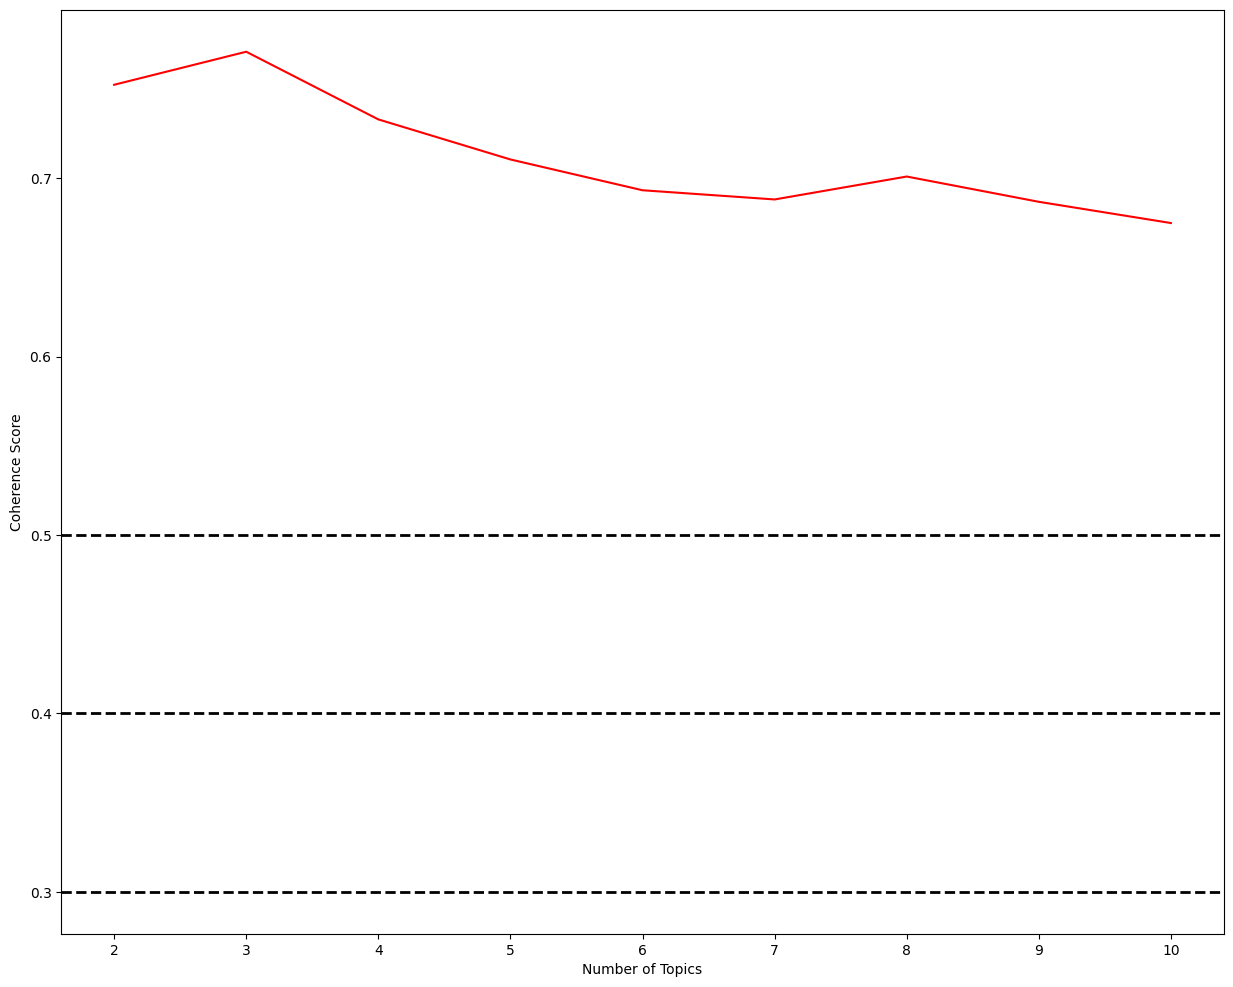

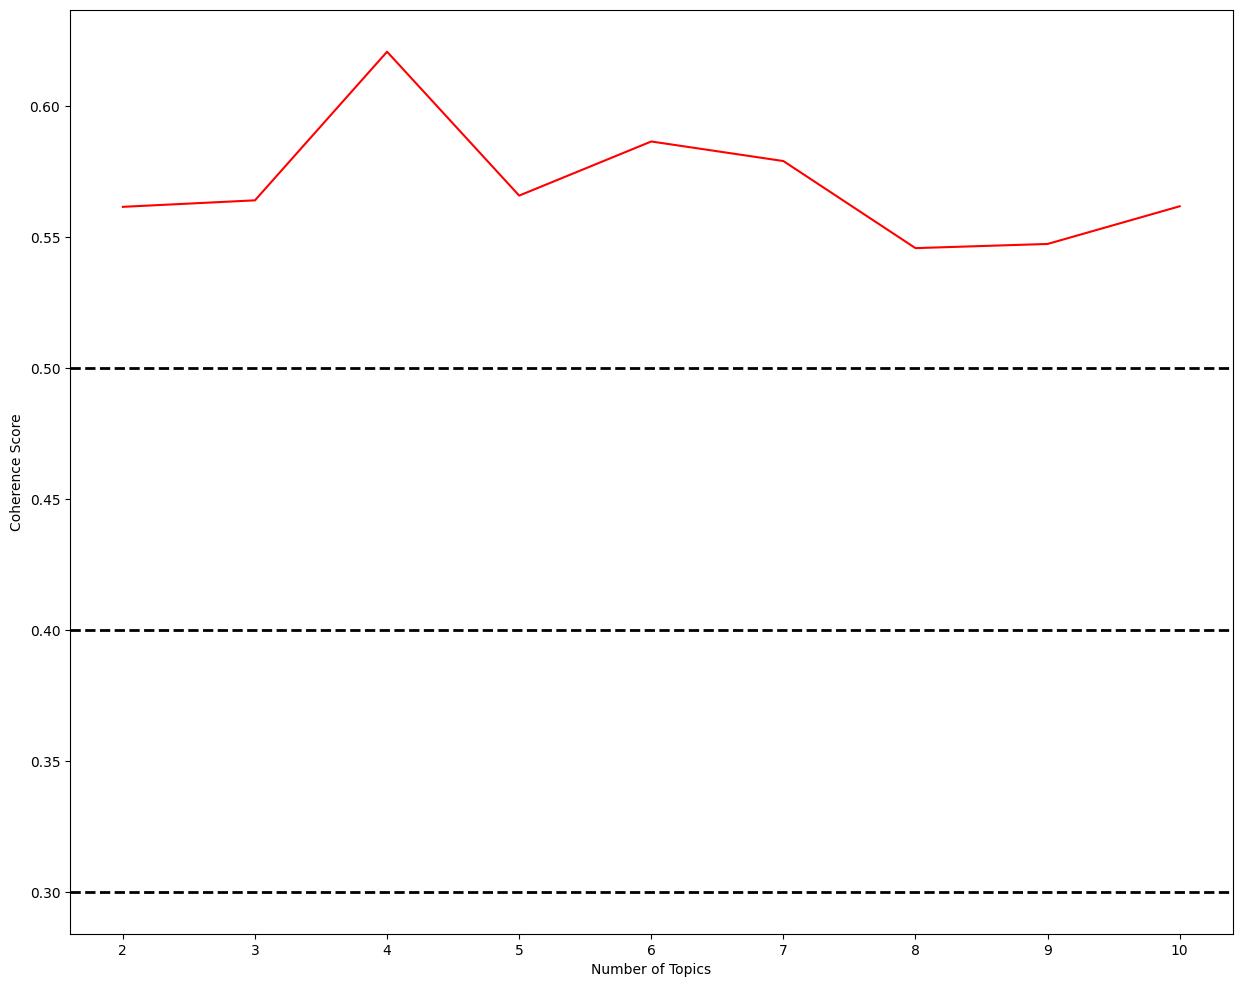

In [9]:
# Calculate coherence scores for each model
target_text = "review_cleaned_v3"

overall_coherence_df = pd.DataFrame() # df to store coherence_df
model_topic_info_list = []  # List to store model_topic_info

for i, df_set in enumerate(df_sets):
    
    print("\nDF NAME: {}\n".format(df_names[i]))

    coherence_df, model_topic_info = topic_model_coherence_plot(df_set, df_names[i], target_text, MODEL_NAMES, START_TOPIC_COUNT, END_TOPIC_COUNT)
    overall_coherence_df = pd.concat([overall_coherence_df, coherence_df], axis=0) # Concatenate to overall_coherence_df
    model_topic_info_list.append(model_topic_info) # Store model_topic_info in a list

In [10]:
# Print all models' coherence scores
overall_coherence_df

,Model Name,Number of Topics,Coherence Score,df_name
0,LSI,2,0.665940,df_pos
1,LSI,3,0.673547,df_pos
2,LSI,4,0.676787,df_pos
3,LSI,5,0.671582,df_pos
4,LSI,6,0.658134,df_pos
5,LSI,7,0.662575,df_pos
6,LSI,8,0.659972,df_pos
7,LSI,9,0.658958,df_pos
8,LSI,10,0.659596,df_pos
0,LDA,2,0.598290,df_pos


In [11]:
# Store coherence scores of all models into "overall_coherence_df", sort by "df_name" and "Coherence Score"
overall_coherence_df = overall_coherence_df.sort_values(["df_name", "Coherence Score"], ascending=False).reset_index(drop=True)
#overall_coherence_df

# Find best model for each df
overall_coherence_best_df = overall_coherence_df.loc[overall_coherence_df.groupby("df_name")["Coherence Score"].idxmax()].reset_index(drop=True)
overall_coherence_best_df

,Model Name,Number of Topics,Coherence Score,df_name
0,LSI,3,0.770990,df_neg
1,LSI,4,0.676787,df_pos


In [12]:
# Print topics of best model
print_best_model_topics(overall_coherence_best_df, model_topic_info_list)


DF NAME: df_neg
MODEL: LSI - NUMBER OF TOPICS: 3

Topic 1: shower, service, bathroom, reception, water, breakfast, toilet, smell, pay, dirty

Topic 2: shower, breakfast, toilet, bathroom, smell, tell, wait, service, dirty, water

Topic 3: breakfast, wait, call, pay, food, tell, mind, restaurant, price, next

----------


DF NAME: df_pos
MODEL: LSI - NUMBER OF TOPICS: 4

Topic 1: great, friendly, station, food, breakfast, helpful, singapore, really, overall, service

Topic 2: great, station, shower, bathroom, use, quite, toilet, provide, walk, really

Topic 3: station, friendly, food, bus, helpful, service, shower, walk, toilet, breakfast

Topic 4: friendly, breakfast, helpful, service, food, station, great, shower, bathroom, reception

----------



In [13]:
end_time = datetime.now()
print("Text processing ended at {}".format(end_time))
print("Text processing spent {}".format(end_time - start_time))

Text processing ended at 2024-06-27 09:52:54.416285
Text processing spent 1:52:56.613557
